In [10]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from util.TrainRoutine import AutoEncTrainRoutine
from util.Evaluator import Evaluator
from util.aedpmerf import AEDPMERF

We want to use the DPMERF algorithm on time series data. But we will not work on time series directly, because it does not model the temporal relation correctly. Instead we will train an AE first and use DPMERF on the encoding space, where there is no notion of time and ordering.

In [3]:
emb_dim = 32
aedpmerf = AEDPMERF()

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


In [4]:
model_name = f"lstmae_180_embed{emb_dim}.pth"
if os.path.exists(f"models/{model_name}"):
    aedpmerf.load_ae(model_name)
else:
    model, history = aedpmerf.train_ae()
    plt.plot(history["train"])
    plt.plot(history["val"])
    aedpmerf.save_ae(model_name)

loading AE model from models/lstmae_180_embed32.pth


In [5]:
enc_df = aedpmerf.encode_train_data(f"data/normal_training_encoded_embed{emb_dim}.csv")
aedpmerf.train_gen(data=enc_df, mini_batch_size=0.1, lr=1e-2)
n_gen_samples = enc_df.shape[0]
gen_data = aedpmerf.generate(n_gen_samples, fname=f"enc_gen_embed{emb_dim}.csv")
pd.DataFrame(gen_data).to_csv(f"data/generated/normal_train_180_embed{emb_dim}_dpmerf.csv")

saving encoded training data in data/normal_training_encoded_embed32.csv
minibatch:  7125
total number of datapoints in the training data is 71243
random freq (1000, 32)
Starting Training
epoch # and running loss are  [0, 4.280483394861221]
epoch # and running loss are  [100, 0.0030128283106023446]
epoch # and running loss are  [200, 0.0016332119048456661]
epoch # and running loss are  [300, 0.0008725596708245575]
epoch # and running loss are  [400, 0.00106661171594169]
epoch # and running loss are  [500, 0.0007954222746775486]
epoch # and running loss are  [600, 0.0007676084496779367]
epoch # and running loss are  [700, 0.0009099405360757373]
epoch # and running loss are  [800, 0.000545723032701062]
epoch # and running loss are  [900, 0.0006581257293873932]
epoch # and running loss are  [1000, 0.0007169145537773147]
epoch # and running loss are  [1100, 0.0007844989813747816]
epoch # and running loss are  [1200, 0.0005497285455930978]
epoch # and running loss are  [1300, 0.000736453333

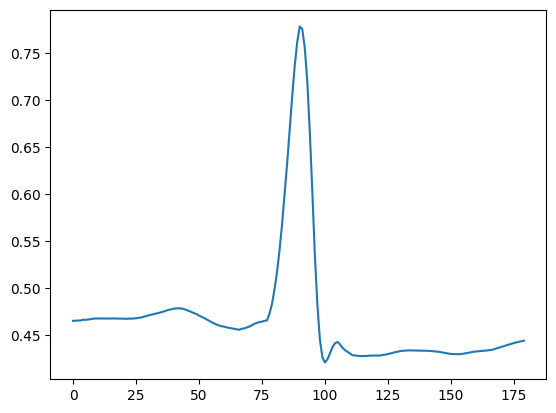

In [6]:
plt.plot(gen_data[30])

In [8]:
ae_gen = AutoEncTrainRoutine(training_data_path=f"data/generated/normal_train_180_embed{emb_dim}_dpmerf.csv")

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


In [9]:
model_name = f"dpmerf_embed{emb_dim}.pth"
if os.path.exists(f"models/{model_name}"):
    ae_gen.load_model(model_name)
else:
    model, history = ae_gen.train_model()
    plt.plot(history["train"])
    plt.plot(history["val"])
    ae_gen.save_model(model_name)

loading AE model from models/dpmerf_embed32.pth


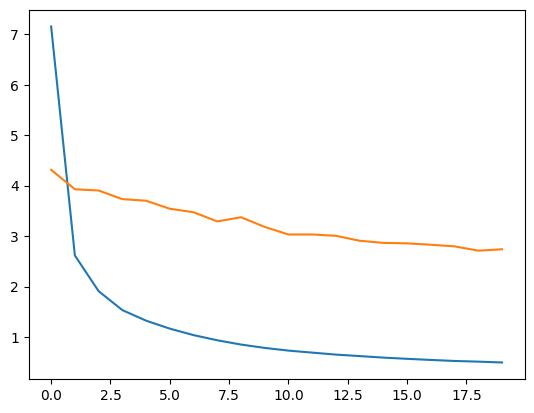

In [ ]:
plt.plot(history["train"])
plt.plot(history["val"])

In [11]:
evaluator = Evaluator(ae_gen.test_normal_ds, ae_gen.test_anomalie_ds, ae_gen.model)

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180, 1])) that is different to the input size (torch.Size([1, 180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


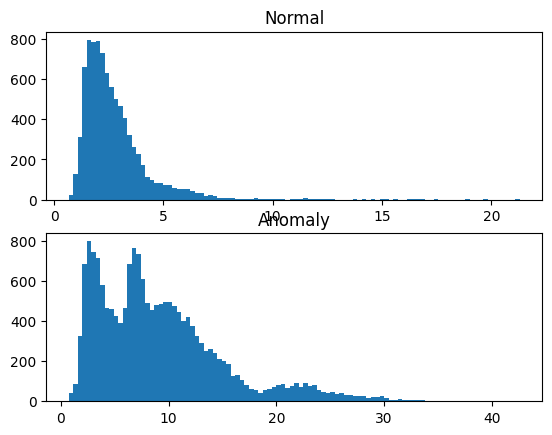

In [12]:
plt.figure()

plt.subplot(2,1,1)
plt.hist(evaluator.loss_normal, bins=100)
plt.title("Normal")

plt.subplot(2,1,2)
plt.hist(evaluator.loss_anomaly, bins=100)
plt.title("Anomaly")

plt.show()

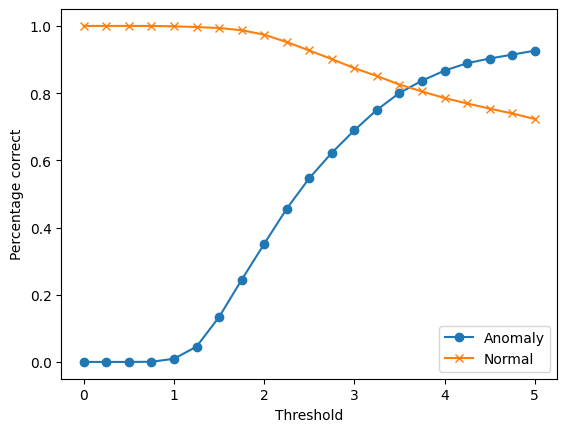

In [13]:
corr_normal, corr_anomaly = evaluator.find_threshold()
plt.plot(np.linspace(0,5,21), corr_normal, marker="o")
plt.plot(np.linspace(0,5,21), corr_anomaly, marker="x")
plt.xlabel("Threshold")
plt.ylabel("Percentage correct")
plt.legend(["Anomaly", "Normal"])
plt.show()

In [14]:
predictions_normal, predictions_anomaly = evaluator.predict_class(3.75)


In [16]:
evaluator.evaluate(predictions_normal, predictions_anomaly)

Acc: 0.8154413682602377
Precision: 0.6766219444954972
Recall: 0.83698988291463
F1: 0.7483103816250826
